# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*


In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
!python --version
import torch
import cv2
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(f'use_cuda={use_cuda}')

Python 3.6.9 :: Anaconda, Inc.
use_cuda=True


In [2]:
import os
import requests
import zipfile

#data_dir = '/data'
data_dir = 'data'

def download(link, path):
    slash_index = link.rfind('/')
    filename = link[slash_index + 1:]
    destiny_file = f'{path}/{filename}'
    print(f'Downloading {link}')
    f = requests.get(link)   
    open(destiny_file, 'wb').write(f.content)
    print(f'{destiny_file} was saved on disk.')
    return destiny_file
    
def unzip(zip_file, extract_dir):
    print(f'Unzipping {zip_file}')
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

def download_datasets_conditionally():
    dogs_link = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip'
    humans_link = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip'
    if os.path.exists(data_dir): 
        print('Datasets already exist. No files were downloaded.')
        return
    os.makedirs(data_dir)
    print(f'"{data_dir}" was created!')
    zip_file = download(dogs_link, data_dir)
    unzip(zip_file, data_dir)
    !mv data/dogImages data/dog_images
    zip_file = download(humans_link, data_dir)
    unzip(zip_file, data_dir)
    
download_datasets_conditionally()

Datasets already exist. No files were downloaded.


In [3]:
import numpy as np
from glob import glob

human_dir = f'{data_dir}/lfw'
dog_dir = f'{data_dir}/dog_images'

# load filenames for human and dog images
human_files = np.array(glob(human_dir + '/*/*'))
dog_files = np.array(glob(dog_dir + '/*/*/*'))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


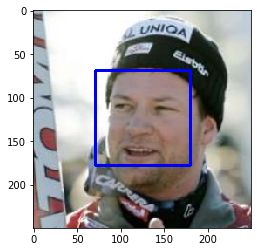

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

What percentage of the first 100 images in human_files have a detected human face?<br/>
`humans_detected_by_human_detector = 99 / 100`

What percentage of the first 100 images in dog_files have a detected human face?<br/>
`dogs_detected_by_human_detector = 20 / 100`

In [6]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def count_positives(images, detector):
    print('Analyzing images ', end = '')
    positives = []
    i = 0
    for image in images:
        positives.append(1 if detector(image) else 0)
        i += 1
        if i % 2 ==0: print('.', end = '')
    print('!')
    return sum(positives), len(images)

humans_detected_by_human_detector, n_humans = count_positives(human_files_short, face_detector)
dogs_detected_by_human_detector, n_dogs = count_positives(dog_files_short, face_detector)
print(f'humans_detected_by_human_detector = {humans_detected_by_human_detector} / {n_humans}')
print(f'dogs_detected_by_human_detector = {dogs_detected_by_human_detector} / {n_dogs}')

Analyzing images ..................................................!
Analyzing images ..................................................!
humans_detected_by_human_detector = 99 / 100
dogs_detected_by_human_detector = 20 / 100


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [7]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(title, confusion_matrix, classes):
    plt.title(title)
    plt.imshow(confusion_matrix, cmap='gray')
    plt.xlabel('Actual class')
    plt.ylabel('Predicted class')
    n_classes = len(classes)
    plt.xlim(-0.5, n_classes - 0.5) 
    plt.ylim(-0.5, n_classes - 0.5) 
    ticks = [i for i in range(n_classes)]
    plt.xticks(ticks, classes)
    plt.yticks(ticks, classes)
    plt.colorbar()
    for x in ticks:
        for y in ticks:
            tf = 'T' if x == y else 'F'
            pn = 'P' if y == 0 else 'N'
            var = f'{tf}{pn}'
            s = f'{var}={confusion_matrix[y][x]}'
            plt.text(x, y, s, horizontalalignment = 'center', verticalalignment = 'center', color = 'r')
    plt.show()
    print_statistics_of_confusion_matrix(confusion_matrix)
    
def print_statistics_of_confusion_matrix(confusion_matrix):
    [tp, fp] = confusion_matrix[0]
    [fn, tn] = confusion_matrix[1]
    p = tp + fn
    n = tn + fp
    print(f'P={p}')
    print(f'N={n}')
    print()
    print(f'TP={tp}')
    print(f'FP={fp}')
    print(f'TN={tn}')
    print(f'FN={fn}')
    
    recall = tp / p
    specificity = tn / n
    precision = tp / (tp + fp)
    npv = tn / (tn + fn)
    print()
    print(f'sensitivity, recall, hit rate, or true positive rate (TPR)={recall}')
    print(f'specificity, selectivity or true negative rate (TNR)={specificity}')
    print(f'precision or positive predictive value (PPV)={precision}')
    print(f'negative predictive value (NPV)={npv}')

    acc = (tp + tn) / (p + n)
    f1 = 2 * precision * recall / (precision + recall)
    print()
    print(f'acc={acc}')
    print(f'F1-score={f1}')
    

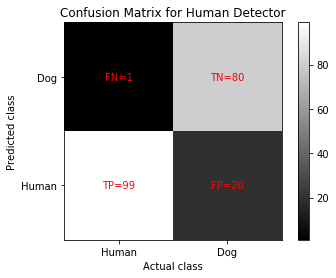

P=100
N=100

TP=99
FP=20
TN=80
FN=1

sensitivity, recall, hit rate, or true positive rate (TPR)=0.99
specificity, selectivity or true negative rate (TNR)=0.8
precision or positive predictive value (PPV)=0.8319327731092437
negative predictive value (NPV)=0.9876543209876543

acc=0.895
F1-score=0.904109589041096


In [9]:
tp = humans_detected_by_human_detector
fn = n_humans - humans_detected_by_human_detector
tn = n_dogs - dogs_detected_by_human_detector
fp = dogs_detected_by_human_detector

draw_confusion_matrix('Confusion Matrix for Human Detector', [[tp, fp], [fn, tn]], ['Human', 'Dog'])

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [10]:
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [11]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

# This function was inspired by this link: 
# https://discuss.pytorch.org/t/how-to-classify-single-image-using-loaded-net/1411
def load_and_preprocess_image_for_vgg16(image_file, image_size = 224):
    image = Image.open(image_file)
    ts = [transforms.Resize((image_size, image_size)), transforms.ToTensor()]
    image_loader = transforms.Compose(ts)
    image = image_loader(image).float()
    image = Variable(image, requires_grad = True)
    image = torch.unsqueeze(image, 0)
    if use_cuda: image = image.cuda()
    return image    

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    image = load_and_preprocess_image_for_vgg16(img_path)
    result = VGG16.forward(image)
    if use_cuda:
        result = result.cpu()
    class_index = np.argmax(result[0].detach().numpy())
    return class_index # predicted class index


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    class_index = VGG16_predict(img_path)
    return 151 <= class_index <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

What percentage of the images in human_files_short have a detected dog?<br/>
`humans_detected_by_dog_detector = 0 / 100`

What percentage of the images in dog_files_short have a detected dog?<br/>
`dogs_detected_by_dog_detector = 94 / 100`

In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# humans_detected_by_dog_detector = face_percentage(human_files_short, dog_detector)
# dogs_detected_by_dog_detector = face_percentage(dog_files_short, dog_detector)
# print(f'humans_detected_by_dog_detector = {humans_detected_by_dog_detector}%, dogs_detected_by_dog_detector = {dogs_detected_by_dog_detector}%')

humans_detected_by_dog_detector, n_humans = count_positives(human_files_short, dog_detector)
dogs_detected_by_dog_detector, n_dogs = count_positives(dog_files_short, dog_detector)
print(f'humans_detected_by_dog_detector = {humans_detected_by_dog_detector} / {n_humans}')
print(f'dogs_detected_by_dog_detector = {dogs_detected_by_dog_detector} / {n_dogs}')

Analyzing images ..................................................!
Analyzing images ..................................................!
humans_detected_by_dog_detector = 0 / 100
dogs_detected_by_dog_detector = 91 / 100


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [14]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.


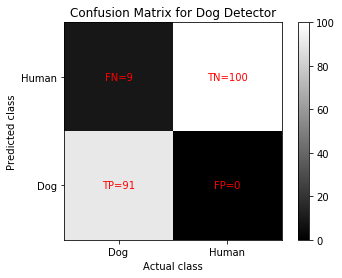

P=100
N=100

TP=91
FP=0
TN=100
FN=9

sensitivity, recall, hit rate, or true positive rate (TPR)=0.91
specificity, selectivity or true negative rate (TNR)=1.0
precision or positive predictive value (PPV)=1.0
negative predictive value (NPV)=0.9174311926605505

acc=0.955
F1-score=0.9528795811518325


In [15]:
tp = dogs_detected_by_dog_detector
fn = n_dogs - dogs_detected_by_dog_detector
tn = n_humans - humans_detected_by_dog_detector
fp = humans_detected_by_dog_detector

draw_confusion_matrix('Confusion Matrix for Dog Detector', np.array([[tp, fp], [fn, tn]]), ['Dog', 'Human'])

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [16]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

import torchvision 
from torchvision import transforms

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

batch_size = 64
image_size = 224
normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_tranforms =\
 [transforms.Resize((image_size, image_size)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  normalize]
train_transform = transforms.Compose(train_tranforms)

test_tranforms =\
 [transforms.Resize((image_size, image_size)),
  transforms.ToTensor(),
  normalize]
test_transform = transforms.Compose(test_tranforms)

train_folder = f'{dog_dir}/train'
valid_folder = f'{dog_dir}/valid'
test_folder = f'{dog_dir}/test'

train_dataset = torchvision.datasets.ImageFolder(root = train_folder, transform = train_transform)
valid_dataset = torchvision.datasets.ImageFolder(root = valid_folder, transform = test_transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_folder, transform = test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, num_workers = 0, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size, num_workers = 0, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, num_workers = 0, shuffle = True)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

**How does your code resize the images (by cropping, stretching, etc)?**

I only resize by stretching. I don't crop.<br/>
I resize in this way:

```
image_size = 224
transforms.Resize((image_size, image_size))
```

**What size did you pick for the input tensor, and why?**

I decided the size of the input tensor to be (224, 224) pixels.<br/>
Why? Because it is the standard input size of ResNet-50.<br/>
So, I use the same tranforms for both neural networks: The scratch neural network and the transfer neural network.

**Did you decide to augment the dataset? If so, how (through translations, flips, rotations, etc)? If not, why not?**

Yes, I augment the dataset only through horizontal flips.<br/>
I don't use vertical flips because such transformation is unnatural.<br/>
I don't use translations because convnets are already translation-invariant.<br/>
I don't use rotations because rotations distort images.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

N_BREEDS = 133

def compute_output_size(input_size, kernel):
    # output_size = (W-F)/S+1
    return int(0.5 * ((input_size - kernel) / 1 + 1))

def square(x):
    return x * x

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        # I partially copied some lines of my own code from the
        # Project 1 - Facial Keypoint Detection (Computer Vision nanodegree)
        
        WIDTH = 224
        n_outputs = N_BREEDS
        basic_colors = 3
        n_features1 = 16
        n_features2 = 32
        n_features3 = 64
        n_features4 = 64
        kernel = 3
        self.conv1 = nn.Conv2d(basic_colors, n_features1, kernel) 
        output_size1 = compute_output_size(WIDTH, kernel)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n_features1, n_features2, kernel) 
        output_size2 = compute_output_size(output_size1, kernel)
        self.conv3 = nn.Conv2d(n_features2, n_features3, kernel) 
        output_size3 = compute_output_size(output_size2, kernel)
        self.conv4 = nn.Conv2d(n_features3, n_features4, kernel) 
        output_size4 = compute_output_size(output_size3, kernel)
        linear1 = n_features4 * square(output_size4)
        linear2 = int(0.25 * linear1)
        linear3 = int(0.25 * linear2)
        print('output_sizes={}'.format([WIDTH, output_size1, output_size2, output_size3, output_size4]))
        print('linear={}\n'.format([linear1, linear2, linear3, n_outputs]))
        self.drop = nn.Dropout(p = 0.25) 
        self.fc1 = nn.Linear(linear1, linear2)        
        self.fc2 = nn.Linear(linear2, linear3)
        self.fc3 = nn.Linear(linear3, n_outputs)
    
    def forward(self, x):
        ## Define forward behavior
        
        # I partially copied some lines of my own code from the
        # Project 1 - Facial Keypoint Detection (Computer Vision nanodegree)
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

output_sizes=[224, 111, 54, 26, 12]
linear=[9216, 2304, 576, 133]

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=9216, out_features=2304, bias=True)
  (fc2): Linear(in_features=2304, out_features=576, bias=True)
  (fc3): Linear(in_features=576, out_features=133, bias=True)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

Basically, I used 4 convolutional layers whose `kernel_size=3` and 4 max pooling layers whose `stride=2`.

I chose `kernel_size=3` because it is small enough to be more statistically significant than `kernel_size=5`.<br/>
How so? Patterns are more repetitive when `kernel_size=3` than when `kernel_size=5`.<br/>
And we are looking for repetitive invariant patterns.

I chose `stride=2` because in this way, convnets act like funnels that narrow the images from a big visual field to a small patch of features.<br/>
While the image size shrinks exponentially in powers of 4 (2 times per dimension, x and y), features should grow somewhat exponentially due to combinatorics.<br/>
Higher levels of complexity should have more combinations of patterns.<br/>
Thus the amount of features grows in this way: 3, 16, 32, 64, and 64.<br/>
The 3 initial features are the RGB values of images.<br/>
Then the amount of features grows in powers of 2: 16, 32, and 64.<br/>
The last layer has 64 features again because 128 is too much. And it is very easy to run out of GPU memory.

Finally, 3 fully connected layers map the feature space into the 133 breeds of dogs.<br/>
Again, these layers also act like funnels that narrow down the feature space into few categories.

Dropout of 0.25 probability of neuronal failure is applied only to the fully connected layers.<br/>
Dropout makes the neural network distribute its experiences throughout the whole neural network.<br/>
Dropout prevent the neural network from having predominant neurons that do most of the work to represent patterns.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [18]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss() 
if use_cuda:
    criterion_scratch.cuda()

### TODO: select optimizer
parameters = model_scratch.parameters()
optimizer_scratch = torch.optim.Adam(parameters)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [19]:
MAX_END_COUNTS = 10 #20

class LogEntry:
    
    def __init__(self, epoch, train_loss, train_acc, valid_loss, valid_acc):
        self.epoch = epoch
        self.train_loss = train_loss
        self.train_acc = train_acc
        self.valid_loss = valid_loss
        self.valid_acc = valid_acc
        
def count_correct_predictions(predicted_target, target):
    pred = predicted_target.data.max(1, keepdim = True)[1]
    return np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())

class Trainer:

    def __init__(self, n_epochs, loaders, model, optimizer, criterion, use_cuda, model_file):
        self.n_epochs = n_epochs
        self.loaders = loaders
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.use_cuda = use_cuda
        self.model_file = model_file
    
    def train_model(self):
        self.model.train()
        self.train_loss = 0.0
        self.train_n_samples = 0
        self.train_correct = 0.
        print('Training', end = '')
        for batch_idx, (data, target) in enumerate(self.loaders['train']):
            if self.use_cuda:
                data, target = data.cuda(), target.cuda()
            predicted_target = self.model.forward(data)
            loss = self.criterion(predicted_target, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            self.train_n_samples += target.size(0)
            self.train_loss += loss.item()
            print('.', end = '')
            self.train_correct += count_correct_predictions(predicted_target, target)
        self.train_loss /= self.train_n_samples
        self.train_acc = self.train_correct / self.train_n_samples

    def test_model(self, dataset_key):
        self.model.eval()
        self.valid_loss = 0.0
        self.valid_n_samples = 0
        self.valid_correct = 0.
        print(f'\nTesting', end = '')
        for batch_idx, (data, target) in enumerate(self.loaders[dataset_key]):
            if self.use_cuda:
                data, target = data.cuda(), target.cuda()
            predicted_target = self.model.forward(data)
            loss = self.criterion(predicted_target, target)
            
            self.valid_n_samples += target.size(0)
            self.valid_loss += loss.item()
            print('.', end = '')
            self.valid_correct += count_correct_predictions(predicted_target, target)
        self.valid_loss /= self.valid_n_samples
        self.valid_acc = self.valid_correct / self.valid_n_samples
            
    def save_model(self):
        if self.valid_acc > self.valid_acc_max:
            self.valid_acc_max = self.valid_acc   
            self.last_saved_epoch = self.epoch
            self.end_counter = 0
            torch.save(self.model.state_dict(), self.model_file)
            print(f'\tNEW maximum validation accuracy found: {self.valid_acc_max:.6f}. Saving model!')
        else:
            self.end_counter += 1
            print(f'\tValidation accuracy is not increasing. End Counter: {self.end_counter}/{self.max_end_counts}')
        has_training_ended = self.end_counter >= self.max_end_counts
        if has_training_ended:
            print(f'Validation accuracy has not increased for {self.max_end_counts} epochs.\nTRAINING IS COMPLETE!')
        return has_training_ended
    
    
    def log_entry(self):
        entry = LogEntry(self.epoch, self.train_loss, self.train_acc, self.valid_loss, self.valid_acc)
        self.log.append(entry)
        print(f'\nepoch={self.epoch}, '\
              f'train_loss={self.train_loss:.6f}, '\
              f'train_acc={self.train_acc * 100:.2f}%, '\
              f'valid_loss={self.valid_loss:.6f}, '\
              f'valid_acc={self.valid_acc * 100:.2f}%')
    
    def start_training(self):
        self.end_counter = 0
        self.max_end_counts = MAX_END_COUNTS
        self.valid_acc_max = -np.Inf 
        self.log = []
        for self.epoch in range(1, self.n_epochs+1):
            self.train_model()
            self.test_model('valid')      
            self.log_entry()
            has_training_ended = self.save_model()
            if has_training_ended: break
    
    def final_test(self):
        self.model.load_state_dict(torch.load(self.model_file))  
        self.test_model('test')
        acc = 100 * self.valid_acc
        correct = int(self.valid_correct)
        print(f'\ntest_loss={self.valid_loss:.6f}, test_acc={acc:.2f}% ({correct}/{self.valid_n_samples})')
        self.test_loss = self.valid_loss
        self.test_acc = self.valid_acc


In [20]:
model_scratch_file = 'model_scratch.pt'
scratch_trainer = Trainer(200, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, model_scratch_file)

In [21]:
scratch_trainer.start_training()

Training.........................................................................................................
Testing..............
epoch=1, train_loss=0.075949, train_acc=1.48%, valid_loss=0.077751, valid_acc=2.16%
	NEW maximum validation accuracy found: 0.021557. Saving model!
Training.........................................................................................................
Testing..............
epoch=2, train_loss=0.070241, train_acc=3.56%, valid_loss=0.071301, valid_acc=4.31%
	NEW maximum validation accuracy found: 0.043114. Saving model!
Training.........................................................................................................
Testing..............
epoch=3, train_loss=0.065482, train_acc=5.12%, valid_loss=0.068253, valid_acc=5.03%
	NEW maximum validation accuracy found: 0.050299. Saving model!
Training.........................................................................................................
Testing..............
epoch=4, tra

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [22]:
scratch_trainer.final_test()


Testing..............
test_loss=0.120632, test_acc=15.07% (126/836)


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def learning_curve(xs, ys1, ys2, x_label, y_label, y_label1, y_label2, title, special_x, last_saved_epoch, special_y, image_file = None):
    fig, ax = plt.subplots()
    ax.plot(xs, ys1, 'bo-', label = y_label1)
    ax.plot(xs, ys2, 'go-', label = y_label2)
    ax.legend()
    ax.axvline(x = special_x, color='r')
    plt.plot(last_saved_epoch, special_y, 'ro') 
    ax.set(xlabel = x_label, ylabel = y_label, title = title)
    ax.grid()
    if image_file is not None:
        fig.savefig(image_file)
    plt.show()
    
def argmin(xs):
    return min(zip(range(len(xs)), xs), key = lambda x: x[1])[0]

def argmax(xs):
    return max(zip(range(len(xs)), xs), key = lambda x: x[1])[0]


In [24]:
def draw_learning_curves(trainer):
    log = trainer.log
    epochs = []
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    for entry in log:
        epochs.append(entry.epoch)
        train_losses.append(entry.train_loss)
        valid_losses.append(entry.valid_loss)
        train_accs.append(entry.train_acc)
        valid_accs.append(entry.valid_acc)
    min_loss_epoch = epochs[argmin(valid_losses)]
    max_acc_epoch = epochs[argmax(valid_accs)]
    learning_curve(epochs, train_losses, valid_losses, 'Epoch', 'Loss', 'Train Loss', 'Valid Loss', 'Learning Curve', min_loss_epoch, trainer.last_saved_epoch, trainer.test_loss)
    learning_curve(epochs, train_accs, valid_accs, 'Epoch', 'Accuracy', 'Train Accuracy', 'Valid Accuracy', 'Learning Curve', max_acc_epoch, trainer.last_saved_epoch, trainer.test_acc)

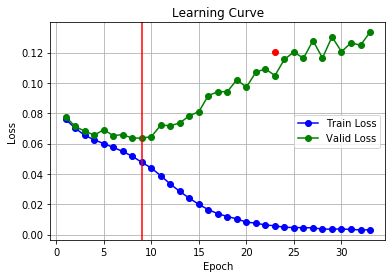

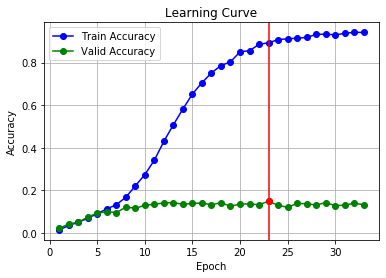

In [25]:
draw_learning_curves(scratch_trainer)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [26]:
## TODO: Specify data loaders

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [27]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

# I partially copied some lines of my own code from the
# Project 2 - Image Captioning (Computer Vision nanodegree)

class TransferConvNet(nn.Module):
    
    def __init__(self, output_size):
        super(TransferConvNet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, output_size)

    def forward(self, images):
        x = self.resnet(images)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

model_transfer = TransferConvNet(N_BREEDS)

if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)

TransferConvNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Basically, I used a ResNet-50 with pretrained weights.
ResNet-50 means it is a residual neural network of 50 layers (very deep) with heterarchical connections (hierarchies are skipped).
Weights were pretrained in the ImageNet dataset.
I removed the last fully connected layer and I created a new fully connected layer whose output size is 133, the number of dog breeds.
I clamped the pretrained weights and I only trained the new fully connected layer I created.
This is the way transfer learning is done. Common patterns of the visual field are transfered from one domain (object recognition) to another similar domain (dog-breed classification).

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [28]:
criterion_transfer = nn.CrossEntropyLoss() 
if use_cuda:
    criterion_transfer.cuda()

parameters = model_transfer.linear.parameters()
optimizer_transfer = torch.optim.Adam(parameters)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [29]:
# train the model
#model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

model_transfer_file = 'model_transfer.pt'
trainer_transfer = Trainer(200, loaders_transfer, model_transfer, optimizer_transfer, 
                           criterion_transfer, use_cuda, model_transfer_file)

In [30]:
trainer_transfer.start_training()

Training.........................................................................................................
Testing..............
epoch=1, train_loss=0.035413, train_acc=55.12%, valid_loss=0.016041, valid_acc=76.05%
	NEW maximum validation accuracy found: 0.760479. Saving model!
Training.........................................................................................................
Testing..............
epoch=2, train_loss=0.010807, train_acc=84.36%, valid_loss=0.011142, valid_acc=80.72%
	NEW maximum validation accuracy found: 0.807186. Saving model!
Training.........................................................................................................
Testing..............
epoch=3, train_loss=0.007232, train_acc=88.85%, valid_loss=0.009407, valid_acc=82.16%
	NEW maximum validation accuracy found: 0.821557. Saving model!
Training.........................................................................................................
Testing..............
epoch=

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [31]:
#test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)
trainer_transfer.final_test()


Testing..............
test_loss=0.009719, test_acc=85.05% (711/836)


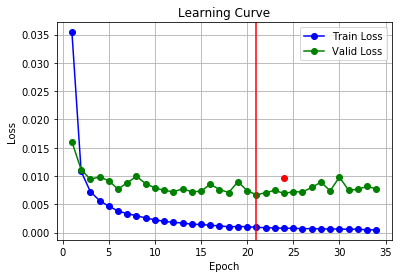

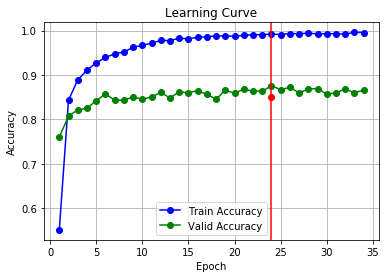

In [32]:
draw_learning_curves(trainer_transfer)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [33]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_dataset.classes]
print(class_names)

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = load_and_preprocess_image_for_vgg16(img_path)
    result = model_transfer.forward(image)
    if use_cuda:
        result = result.cpu()
    class_index = np.argmax(result[0].detach().numpy())    
    return class_names[class_index], class_index

['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute', 'American eskimo dog', 'American foxhound', 'American staffordshire terrier', 'American water spaniel', 'Anatolian shepherd dog', 'Australian cattle dog', 'Australian shepherd', 'Australian terrier', 'Basenji', 'Basset hound', 'Beagle', 'Bearded collie', 'Beauceron', 'Bedlington terrier', 'Belgian malinois', 'Belgian sheepdog', 'Belgian tervuren', 'Bernese mountain dog', 'Bichon frise', 'Black and tan coonhound', 'Black russian terrier', 'Bloodhound', 'Bluetick coonhound', 'Border collie', 'Border terrier', 'Borzoi', 'Boston terrier', 'Bouvier des flandres', 'Boxer', 'Boykin spaniel', 'Briard', 'Brittany', 'Brussels griffon', 'Bull terrier', 'Bulldog', 'Bullmastiff', 'Cairn terrier', 'Canaan dog', 'Cane corso', 'Cardigan welsh corgi', 'Cavalier king charles spaniel', 'Chesapeake bay retriever', 'Chihuahua', 'Chinese crested', 'Chinese shar-pei', 'Chow chow', 'Clumber spaniel', 'Cocker spaniel', 'Collie',

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [34]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

import matplotlib.pyplot as plt

def draw_image(ax, img, label):
    imgplot = ax.imshow(img)
    ax.set_title(label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def draw_images(images, labels):
    arrow_image = Image.open('images2/arrow.png')
    n_images = len(images)
    fig, axs = plt.subplots(nrows = 1, ncols = n_images + 1, figsize=(9, 6))
    for ax, i in zip(axs.flat, range(n_images + 1)):
        if i == 0: draw_image(ax, Image.open(images[i]), labels[i])
        if i == 1: 
            label = 'PREDICTED BREED' if labels[0] == 'DOG' else 'MOST SIMILAR TO'
            draw_image(ax, arrow_image, label)
        if i > 1: draw_image(ax, Image.open(images[i - 1]), labels[i - 1])

def get_dir(class_index):
    prefix = 'data/dog_images/train'
    dirs = os.listdir(prefix)
    for dir in dirs:
        index = dir.find('.')
        if index != -1:
            #print(class_index, index, dir, dir[:index])
            if class_index + 1 == int(dir[:index]): 
                return f'{prefix}/{dir}'
            
def get_random_image_files(dir, n):
    files = os.listdir(dir)
    random_files = []
    for i in range(n):
        r = int(np.random.random() * len(files))
        random_files.append(files.pop(r))
    return random_files
        
def get_row(image, label, index):
    images = [f'images2/{image}']
    labels = [label]
    dir = get_dir(index)
    random_files = get_random_image_files(dir, 3)
    for random_file in random_files:
        labels.append(class_names[index])
        images.append(f'{dir}/{random_file}')
    return images, labels

def show_row(image, label):
    breed, index = predict_breed_transfer(f'images2/{image}')
    row_images, labels = get_row(image, label, index)
    draw_images(row_images, labels)

def human_or_dog(img_path):
    dog = dog_detector(img_path)
    human = face_detector(img_path)
    if dog and not human: return "DOG"
    if human and not dog: return "HUMAN"
    return 'UNDEFINED'

def run_app(image):
    ## handle cases for a human face, dog, and neither
    img_path = f'images2/{image}'
    label = human_or_dog(img_path)
    show_row(image, label)


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Yes, the output is better than I expected.

I tested the Dog App with 4 photos of mine.<br/>
I was surprised and even flattered that the convnet said I'm similar to such cute dogs: Bichon frise and Maltese.

I also tested 2 photos of my black squirrel called Negrita.<br/>
The convnet said she is similar to Kerry blue terriers and Australian cattle dogs.

Finally, I tested the convnet with 3 photos of real dogs: 1 Saint Bernard, 1 Bulldog, and 1 Husky.<br/>
The convnet correctly guessed the Saint Bernard and the Bulldog.<br/>
And the convnet didn't have the Husky category but guessed a very similar dog: The Alaskan malamute.

**Three possible points for improvement:**
1. I used a very good convnet, the ResNet-50. However, there are other convnets with state-of-the-art results. I could use them.
2. When I did transfer learning, I changed the last part of the convnet with a single fully-connected layer. I could make the final part even deeper with multiple fully-connected layers.
3. I could augment the training dataset by using Generative Adversarial Networks (GANs).

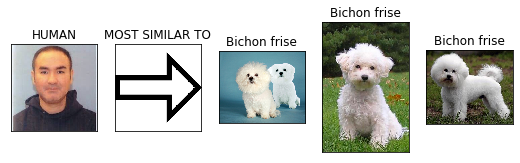

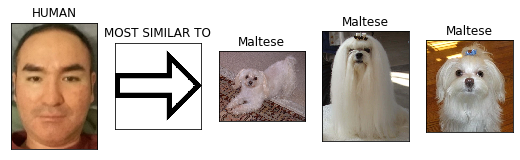

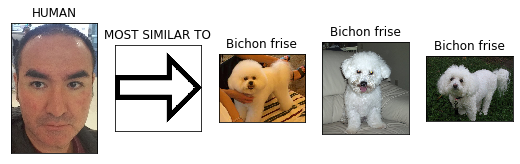

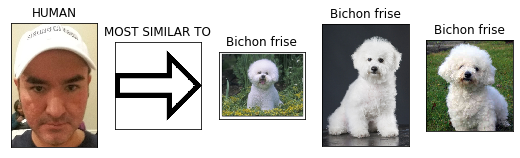

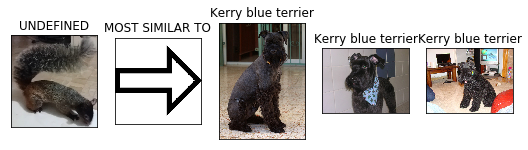

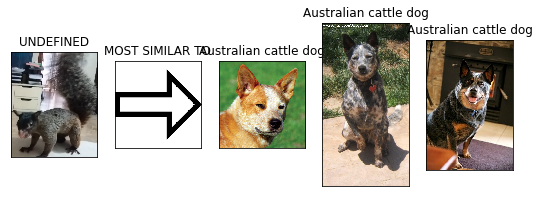

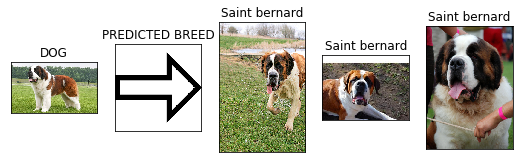

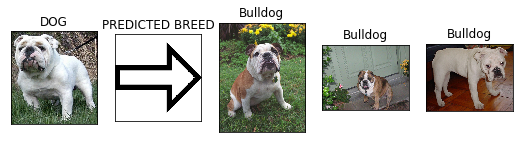

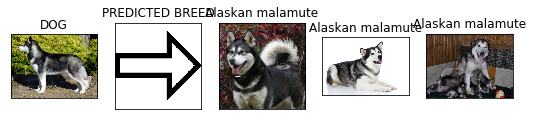

In [35]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

images = ['jckuri1.jpg', 'jckuri2.jpg', 'jckuri3.jpg', 'jckuri4.jpg', 'Negrita.jpg', 'Negrita2.jpg', 'saint-bernard.jpeg', 'white-bulldog.jpg', 'Siberian-husky.jpg']

for image in images:
    run_app(image)
